In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [3]:
# 讀取資料
# 1) 讀取資料並跳過前兩行
tsla_df = pd.read_csv("data/tsla_df.csv", skiprows=[0, 1])

# 2) 手動設定正確欄位名稱
tsla_df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']

# 3) 轉成 datetime
tsla_df['Date'] = pd.to_datetime(tsla_df['Date'])

# 4) 新增 weekday
tsla_df['date_weekday'] = tsla_df['Date'].dt.dayofweek

tsla_df.head()

,Date,Close,High,Low,Open,Volume,date_weekday
0,2020-01-02,28.684000,28.713333,28.114000,28.299999,142981500,3
1,2020-01-03,29.534000,30.266666,29.128000,29.366667,266677500,4
2,2020-01-06,30.102667,30.104000,29.333332,29.364668,151995000,0
3,2020-01-07,31.270666,31.441999,30.224001,30.760000,268231500,1
4,2020-01-08,32.809334,33.232666,31.215334,31.580000,467164500,2


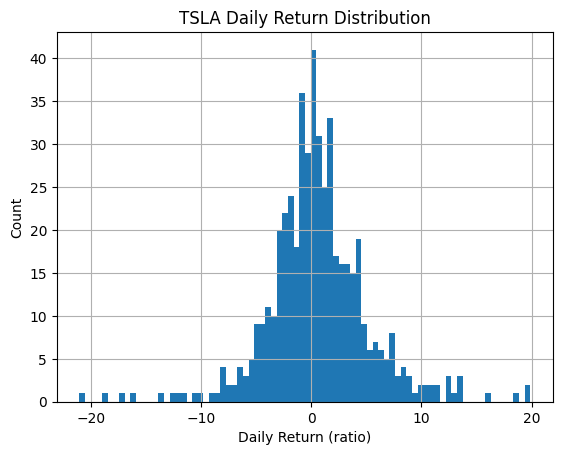

netChangeRatio
(-21.064, -4.145]    51
(-4.145, -2.361]     50
(-2.361, -1.157]     50
(-1.157, -0.397]     51
(-0.397, 0.299]      50
(0.299, 1.223]       50
(1.223, 2.052]       51
(2.052, 3.685]       50
(3.685, 5.915]       50
(5.915, 19.895]      51
Name: count, dtype: int64

In [4]:
# 觀察TSLA股價的漲跌是否常態分布
# 若 Close 是字串 → 轉成浮點數

tsla_df['Close'] = pd.to_numeric(tsla_df['Close'].astype(str).str.replace(',', ''), errors='coerce')

# 計算漲跌幅 (日報酬率)，轉換成%
tsla_df['netChangeRatio'] = tsla_df['Close'].pct_change()
tsla_df['netChangeRatio'] = tsla_df['netChangeRatio'] * 100

# 去除 NaN 再畫直方圖
tsla_df['netChangeRatio'].dropna().hist(bins=80)

plt.xlabel('Daily Return (ratio)')
plt.ylabel('Count')
plt.title('TSLA Daily Return Distribution')
plt.show()

# 用 value_count() 搭配 qcrt 將報酬分組
cats = pd.qcut(tsla_df['netChangeRatio'], 10)
cats.value_counts().sort_index()

In [5]:
# 資料的離散化：原本是連續的漲幅，現在變成離散的報酬分組
bins = [-7, -5, -3, 0, 3, 5, 7, np.inf]
cats = pd.cut(tsla_df['netChangeRatio'], bins=bins)
cats.value_counts().sort_index()

# 用 pd.get_dummies() 得到one-hot encoding格式
change_ration_dummies = pd.get_dummies(cats, prefix='cr_dummies')
change_ration_dummies.tail()

# 得到的就是股票每天的漲幅位於哪個區間（True)

,"cr_dummies_(-7.0, -5.0]","cr_dummies_(-5.0, -3.0]","cr_dummies_(-3.0, 0.0]","cr_dummies_(0.0, 3.0]","cr_dummies_(3.0, 5.0]","cr_dummies_(5.0, 7.0]","cr_dummies_(7.0, inf]"
500,False,False,False,True,False,False,False
501,False,False,True,False,False,False,False
502,False,False,True,False,False,False,False
503,False,False,True,False,False,False,False
504,False,False,True,False,False,False,False


In [6]:
# 把 dummies 跟原本的 df 合併
tsla_df_concat = pd.concat([tsla_df, change_ration_dummies], axis=1)

positive       0   1
date_weekday        
0             33  62
1             49  55
2             42  62
3             48  55
4             52  47


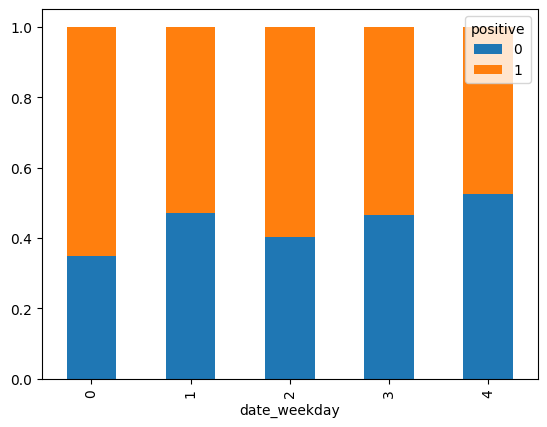

,positive
date_weekday,
0,0.652632
1,0.528846
2,0.596154
3,0.533981
4,0.474747


In [7]:
# 分析看看 tsla 一段時間內的股價是否有每週星期幾的買賣差異
# 用 positive 紀錄漲的日期，為True標記為1反之為0
tsla_df['positive'] = np.where(tsla_df['netChangeRatio'] > 0, 1, 0)

# 建立交叉比對表並視覺化，看一下漲跌跟星期幾的關係
xt = pd.crosstab(tsla_df.date_weekday, tsla_df.positive)
print(xt)
xt_pct = xt.div(xt.sum(axis=1).astype(float), axis=0)
xt_pct.plot(kind='bar', stacked=True)
plt.show()

# 建立透視表
tsla_df.pivot_table(['positive'], index=['date_weekday'])

# 輸出顯示：週一有百分之65的機率是上漲的，週五則有百分之53(100-47)是下跌的

In [11]:
# 把檔案儲存起來供下個章節使用
tsla_df.to_csv('data/tsla_df_dummies.csv', index=False)
